# Patent analysis

We collect, integrate and enrich patent data for the BEIS dashboard.

Patent data is complex. [Data dictionary](https://github.com/nestauk/patent_analysis/raw/master/references/patstat_data_dict.pdf) and [guide](https://github.com/nestauk/patent_analysis/raw/master/references/The_Patents_Guide_2nd_edition.pdf)

### Preamble

In [1]:
%run ../notebook_preamble.ipy

from data_getters.labs.core import download_file
import random
from ast import literal_eval

In [2]:
def make_dirs(name,dirs = ['raw','processed']):
    '''
    Utility that creates directories to save the data
    
    '''
    
    for d in dirs:
        if name not in os.listdir(f'../../data/{d}'):
            os.mkdir(f'../../data/{d}/{name}')

In [3]:
#This is to download the data from nesta data getters

def patent_download(file_path=None, progress=True):
    """ Fetch patent data

    Repo: http://github.com/nestauk/patent_analysis
    Commit: cb11b3f
    File: https://github.com/nestauk/patent_analysis/blob/master/notebooks/02-jmg-patent_merge.ipynb

    Args:
        file_path (`str`, optional): Path to download to. If None, stream file.
        progress (`bool`, optional): If `True` and `file_path` is not `None`,
            display download progress.
    """
    itemname = "Scotland_temp/15_10_2019_patents_combined.csv"
    return download_file(itemname, file_path, progress)

In [4]:
def make_data_dict(table,name,path,sample=5):
    '''
    A function to output the form for a data dictionary
    
    Args:
        -table (df) is the df we want to create the data dictionary for
        -name (str) of the df
        -path (str) is the place where we want to save the file
        

    
    '''
    
    types = [estimate_type(table[x],sample=sample) for x in table.columns]
        
    data_dict = pd.DataFrame()
    data_dict['variable'] = table.columns
        
    data_dict['type'] = types
    
    data_dict['description'] = ['' for x in data_dict['variable']]
        
    out = os.path.join(path,f'{today_str}_{name}.csv')
    
    #print(data_dict.columns)
    
    data_dict.to_csv(out)
    

def estimate_type(variable,sample):
    '''
    Estimates the type of a column. 

    Args:
        variable (iterable) with values
        sample (n) is the number of values to test
    
    '''
    
    selection = random.sample(list(variable),sample)
    
    types = pd.Series([type(x) for x in selection]).value_counts().sort_values(ascending=False)
    
    return(types.index[0])

                
def flat_freq(a_list):
    '''
    Return value counts for categories in a nested list
    
    '''
    return(pd.Series([x for el in a_list for x in el]).value_counts())

        

def flatten_list(a_list):
    
    return([x for el in a_list for x in el])

        

In [5]:
def count_patenting_in_nuts(df,variable,nuts_lookup,pat_fam_id='docdb_family_id'):
    '''
    This function creates counts of inventors and applicants in NUTS areas.
    
    Note that the NUTS areas are not available at an standardised level of resolution. We will prune the length of NUTS3 (length of code>4) and match with the 
    nuts2 code lookup. This also means we will throw away any patents that don't have better level of resolution than NUTS2.
    
    Args:
        df (dataframe) is the df with the patent information. Each row is a patent id and the columns contain metadata, authorship etc.
        variable (str) is the variable we want to use in the analysis
        pat_fam_id (str) is the patent family variable that we want to focus on
        nuts_lookup (dict) is the nuts2 code to name lookup
    
    '''
    
    #Group by patent families
    
    #This gives us a set of nuts regions involved in a single invention. 
    #Note that this is binary (whether a nuts region participates in an invention, rather than the number of participants)
    #That would require a different approach using a person - patent lookup
    
    
    #All this drama is because we are concatenating lists, so we need to flatten them first
    # This gives us the NUTS involved in a patent family
    fam = df.dropna(
        axis=0,subset=[variable]).groupby(pat_fam_id)[variable].apply(lambda x: list(set(flatten_list(list(x))))
                                                                     ).reset_index(drop=False)
    
    
    #We need the earliest application year for every patent id
    fam_year_lookup = df.drop_duplicates(pat_fam_id).set_index(pat_fam_id)['earliest_publn_year'].to_dict()
    
    #This adds a year field to the fam df
    fam['earliest_publn_year'] = [fam_year_lookup[x] for x in fam[pat_fam_id]]
    
    #In Fam, we have in some cases multiple NUTS per application. We extract them using the unfold field variable
    #We also concatenate them
    fam_unfolded = pd.concat([unfold_field(x,variable,'earliest_publn_year') for item,x in fam.iterrows()])
    
    #We extract the nuts 2 using nuts lookup. Note that there will be some missing values (eg the 'UK') value
    fam_unfolded['nuts_2'] = [nuts_lookup[x] if x in nuts_lookup.keys() else np.nan for x in fam_unfolded[variable]]

    #Crosstab to obtain the counts of NUTS2 per year
    patent_year_counts = pd.crosstab(fam_unfolded['nuts_2'],fam_unfolded['earliest_publn_year']).reset_index(drop=False)

    #And melt
    patent_year_counts_long = patent_year_counts.melt(id_vars='nuts_2').set_index(['nuts_2','earliest_publn_year'])
    
    patent_year_counts_long.rename(columns={'value':variable+'_n'},inplace=True)
    
    return(patent_year_counts_long)

In [6]:
def unfold_field(pat_item,variable,year_var):
    '''
    Some of the family patents involve multiple NUTS. We need to extract those so that we have one NUTS to year.
    
    Args:
        pat_item (df item) is an item with a list of nuts involved in a patent family and the earliest year when it was files
        variable (str) is the name of the variable (could be inventor nuts) 
        year_var (str) is the name of the year variable
    
    '''
    
    nuts = []
    years = []
    
    for n in pat_item[variable]:
        nuts.append(n)
        years.append(pat_item[year_var])

    out = pd.DataFrame({variable:nuts,year_var:years})
    
    return(out)

In [23]:
def make_indicator(table,target_path,var_lookup,year_var,nuts_var='nuts_code',nuts_spec=2018):
    '''
    We use this function to create and save indicators using our standardised format.
    
    Args:
        table (df) is a df with relevant information
        target_path (str) is the location of the directory where we want to save the data (includes interim and processed)
        var_lookup (dict) is a lookup to rename the variable into our standardised name
        year (str) is the name of the year variable
        nuts_var (str) is the name of the NUTS code variable. We assume it is nuts_code
        nuts_spec (y) is the value of the NUTS specification. We assume we are working with 2018 NUTS
    
    '''
    #Copy
    t = table.reset_index(drop=False)
    
    #Reset index (we assume that the index is the nuts code, var name and year - this might need to be changed)
    
    
    #Process the interim data into an indicator
    
    #This is the variable name and code
    var_name = list(var_lookup.keys())[0]
    
    var_code = list(var_lookup.values())[0]
    
    #Focus on those
    t = t[[year_var,nuts_var,var_name]]
    
    #Add the nuts specification
    t['nuts_year_spec'] = nuts_spec
    
    #Rename variables
    t.rename(columns={var_name:var_code,year_var:'year',nuts_var:'nuts_id'},inplace=True)

    
    #Reorder variables
    t = t[['year','nuts_id','nuts_year_spec',var_code]]
    
    print(t.head())
    
    #Save in the processed folder
    t.to_csv(f'../../data/processed/{target_path}/{var_code}.csv')
    
def autonuts_folder(path):
    '''
    Applies autonuts to all the files in a folder
    
    '''
    
    csvs = [x for x in os.listdir(path) if '.csv' in x]
    
    for x in csvs:
        
        print(x)
        
        table = pd.read_csv(os.path.join(path,x))
        
        an = auto_nuts2_uk(table)
        
        an.to_csv(os.path.join(path,x),index=False)

In [8]:
make_dirs('patents',['raw','processed','interim'])

## 1. Read data

We read a patent dataset based on the processing and analysis that we undertook [here](https://github.com/nestauk/patent_analysis)

In the patent file that we read every row is a patent application and the columns contain information about it. In some cases, the columns contain lists of applicants, IPC codes and other things.



In [10]:
p_d = patent_download()

p = pd.read_csv(p_d)

In [11]:
p.head()

,Unnamed: 0,appln_nr,ipr_type,granted,appln_auth,appln_filing_year,earliest_publn_year,docdb_family_id,inpadoc_family_id,nb_citing_docdb_fam,...,inv_lad_name,inv_nuts,appln_abstract_lg,appln_abstract,tf_weight,tf_techn_field_nr,tf_techn_field,ipc_class_symbol_proc_10,inv_nuts_name,appl_nuts_name
0,5049666,2915959,PI,N,CA,2014,2014,48914775,2357602,1,...,['missing'],['UK'],en,An energy absorber comprising a housing for at...,"[0.5, 0.5]","[31, 34]","['Mechanical elements', 'Other consumer goods']","['A62B003504', 'F16F000712']",['UNITED KINGDOM'],NaN
1,330220543,11150120,PI,N,EP,2011,2012,44259757,8845816,7,...,"['Reigate and Banstead', 'Reigate and Banstead...","['UKJ26', 'UKJ26', 'UKJ26', 'UKJ26']",en,A method of manufacturing a vertical transisto...,[1.0],[8],['Semiconductors'],"['H01L002133', 'H01L002940', 'H01L002942', 'H0...","['East Surrey', 'East Surrey', 'East Surrey', ...",NaN
2,330220545,11150121,PI,N,EP,2011,2012,44064927,8683210,6,...,"['Reigate and Banstead', 'Reigate and Banstead']","['UKJ26', 'UKJ26']",en,An electroacoustic transducer (speaker or micr...,[1.0],[2],['Audio-visual technology'],"['H04R000704', 'H04R000904']","['East Surrey', 'East Surrey']",NaN
3,330220579,11150138,PI,N,EP,2011,2012,44146389,8680186,3,...,NaN,NaN,en,"A coil (12, 112, 212) is described, the coil (...","[0.33333334, 0.6666667]","[8, 1]","['Semiconductors', 'Electrical machinery, appa...","['H01F000606', 'H01L003916', 'H02H000902']",NaN,['Northumberland']
4,330225225,11150145,PI,N,EP,2011,2012,44012471,32347678,3,...,['Mid Suffolk'],['UKH14'],en,The present invention relates to motor constru...,[1.0],[1],"['Electrical machinery, apparatus, energy']",['H02K000114'],['Suffolk'],NaN


In [12]:
#We need to parse some of the lists in the data

#These are the list variables that we need to parse
list_vars = ['appl_psn_name','appl_person_address','appl_laua','appl_lad_name','appl_uk_postcode_long',
           'inv_psn_name','inv_person_address','inv_laua','inv_lad_name','inv_uk_postcode_long','tf_weight','tf_techn_field_nr', 'tf_techn_field', 'ipc_class_symbol_proc_10',
            'appl_nuts_name','inv_nuts_name','appl_nuts','inv_nuts']


for v in list_vars:
    
    print(v)
    
    
    p[v] = [literal_eval(x) if pd.isnull(x)==False else np.nan for x in p[v]]
    
    #Bring back the misssing variables
    if any(l in v for l in ['lad','laua','nuts','ttwa']):
        p[v] = [np.nan if type(var)!=list else np.nan if all(x=='missing' for x in var) else var for var in p[v]]
        

appl_psn_name
appl_person_address
appl_laua
appl_lad_name
appl_uk_postcode_long
inv_psn_name
inv_person_address
inv_laua
inv_lad_name
inv_uk_postcode_long
tf_weight
tf_techn_field_nr
tf_techn_field
ipc_class_symbol_proc_10
appl_nuts_name
inv_nuts_name
appl_nuts
inv_nuts


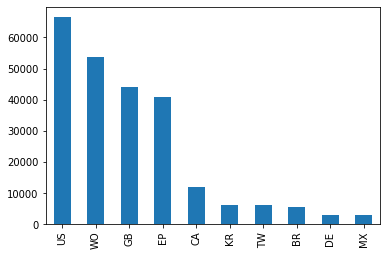

In [13]:
p['appln_auth'].value_counts().head(n=10).plot.bar()

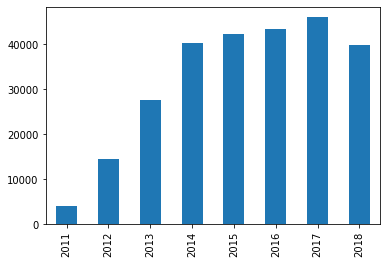

In [14]:
p['earliest_publn_year'].value_counts().loc[np.arange(2011,2019)].plot.bar()

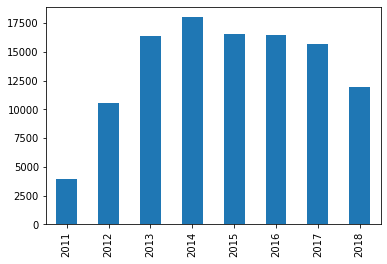

In [15]:
p.groupby('docdb_family_id')['earliest_publn_year'].min().value_counts().loc[np.arange(2011,2019)].plot.bar()

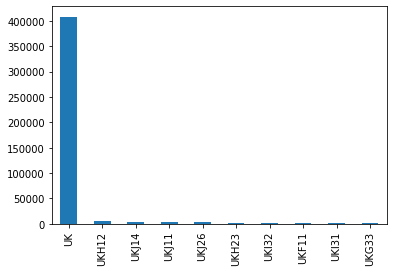

In [16]:
flat_freq(p['inv_nuts'].dropna()).head(n=10).plot.bar()

### Metadata: NUTS lookup

Read [NUTS lookup](http://geoportal1-ons.opendata.arcgis.com/datasets/9b4c94e915c844adb11e15a4b1e1294d_0.csv)

In [17]:
nuts = pd.read_csv('https://opendata.arcgis.com/datasets/d266cbe2179a4766b4de7c6e73b4a285_0.csv')
#nuts = pd.read_csv('http://geoportal1-ons.opendata.arcgis.com/datasets/9b4c94e915c844adb11e15a4b1e1294d_0.csv')

In [18]:
#This is a NUTS 2 lookup FOR 2015
nuts_2_code_name_lookup = nuts.drop_duplicates('NUTS215CD').set_index('NUTS215CD')['NUTS215NM'].to_dict()

#nuts_2_code_name_lookup = nuts.drop_duplicates('NUTS218CD').set_index('NUTS218CD')['NUTS218NM'].to_dict()

#We create a lookup between NUTS2 and NUTS3 codes
nuts_3_to_2 = nuts.set_index('NUTS315CD')['NUTS215CD'].to_dict()

In [19]:
#This is a NUTS code - lookup name for all NUTS codes regardless of their level
with open('../../data/aux/patstat_nuts_lookup.json','r') as infile:
    nuts_patstat_lookup = json.load(infile)

## 2. Process data

Create count of applications and inventions per NUTS area and year focusing on the earliest publication year. We focus on patent families to avoid double counting.

In [28]:
pat_nuts = pd.concat(
    [count_patenting_in_nuts(p.loc[(p['earliest_publn_year']>2012)&(p['earliest_publn_year']<2019)],var,nuts_3_to_2) 
     for var in ['inv_nuts','appl_nuts']],axis=1).fillna(0)

In [29]:
pat_nuts.head()

,,inv_nuts_n,appl_nuts_n
nuts_2,earliest_publn_year,,
UKC1,2013,157,37
UKC2,2013,170,72
UKD1,2013,43,15
UKD3,2013,274,135
UKD4,2013,109,74


Interesting -many more applications than inventors in London

## 3. Output indicators

In [30]:
from beis_indicators.utils.nuts_utils import auto_nuts2_uk

In [31]:
make_indicator(pat_nuts.sort_values(['nuts_2','earliest_publn_year']),'patents',{'inv_nuts_n':'total_inventions'},'earliest_publn_year',nuts_var='nuts_2',nuts_spec=2013)

   year nuts_id  nuts_year_spec  total_inventions
0  2013    UKC1            2013               157
1  2014    UKC1            2013               162
2  2015    UKC1            2013               152
3  2016    UKC1            2013                99
4  2017    UKC1            2013                32


In [32]:
autonuts_folder('../../data/processed/patents/')

total_inventions.csv
